In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mixedbridge.stochastic_processes.examples import OUProcess, OUAuxProcess, OUBridgeProcess
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess, MixedGuidedBridgeProcess
from mixedbridge.stochastic_processes.wiener import WienerProcess
from mixedbridge.solvers.sde import Euler

**$\mathbb{P}$: OU process**
$$
\mathrm{d}X_t = -\gamma\cdot X_t\mathrm{d}t + \sigma\mathrm{d}W_t
$$
**$\mathbb{P}^*$: OU Bridge**
$$
\mathrm{d}X^*_t = \left\{ -\gamma\cdot X_t + \frac{4\gamma^2e^{-\gamma(T-t)}(X^*_t\cdot e^{-\gamma(T-t)} - X_T)}{e^{-2\gamma(T-t)} - 1}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
**$\mathbb{P}^\circ$: Brownian bridge**
$$
\mathrm{d}X^\circ_t = \frac{X_T-X^\circ_t}{T-t}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
**$\mathbb{P}^\diamond$: Brownian bridge + NN**
$$
\mathrm{d}X^\diamond_t = \left\{\frac{X_T-X^\diamond_t}{T-t} + \sigma\cdot\nu_\theta(t, X^\diamond_t)\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
Set $\sigma=\gamma=1$

**With closed-form scores**

The optimal value of $\nu_\theta(t, x)$ should be $\nabla_x\log\frac{p(t, x;T, x_T)}{\tilde{p}(t, x;T, x_T)}$. Find that:
$$
\nabla_x\log p(t, x;T, x_T) = \frac{4\gamma^2e^{-\gamma(T-t)}(x\cdot e^{-\gamma(T-t)} - x_T)}{\sigma^2(e^{-2\gamma(T-t)} - 1)}
$$
and
$$
\nabla_x\log \tilde{p}(t, x;T, x_T) = \frac{x_T - x}{\sigma^2(T-t)}
$$

In [3]:
dim = 1
sigma = 1.0
gamma = 1.0
T = 1.0
dt = 1./ 100
dtype = jnp.float32
rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.0], dtype=dtype)
xT = jnp.array([1.0], dtype=dtype)

In [4]:
def score_p(t, x):
    return 4.0 * gamma**2 * jnp.exp(-gamma * (T - t)) * (x * jnp.exp(-gamma * (T - t)) - xT) \
        / ((jnp.exp(-2.0 * gamma * (T - t)) - 1.0) * sigma**2)

def score_p_tilde(t, x):
    return (xT - x) / ((T - t) * sigma**2)

def optimal_nu(t, x):
    return sigma * (score_p(t, x) - score_p_tilde(t, x))

In [11]:
wiener_process = WienerProcess(T=T, dt=dt, dim=dim, dtype=dtype)
ou_proc = OUProcess(gamma=gamma, sigma=sigma, T=T, dt=dt, dim=dim, dtype=dtype)
ou_aux_proc = OUAuxProcess(sigma=sigma, T=T, dt=dt, dim=dim, dtype=dtype)
ou_bridge_proc = OUBridgeProcess(gamma=gamma, sigma=sigma, T=T, dt=dt, dim=dim, dtype=dtype, xT=xT)

L0 = jnp.eye(dim, dtype=dtype)
Sigma0 = jnp.eye(dim, dtype=dtype) * 1e-10
ou_guided_bridge_proc = GuidedBridgeProcess(L0=L0, Sigma0=Sigma0, ori_proc=ou_proc, aux_proc=ou_aux_proc, x0=x0, xT=xT)

In [12]:
ou_solver = Euler(ou_proc, wiener_process)
ou_guided_bridge_solver = Euler(ou_guided_bridge_proc, wiener_process)
ou_bridge_solver = Euler(ou_bridge_proc, wiener_process)

In [13]:
n_batches = 64
rng_key, _ = jax.random.split(rng_key)
ou_guided_bridge_path = ou_guided_bridge_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=n_batches)
ou_bridge_path = ou_bridge_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=n_batches)

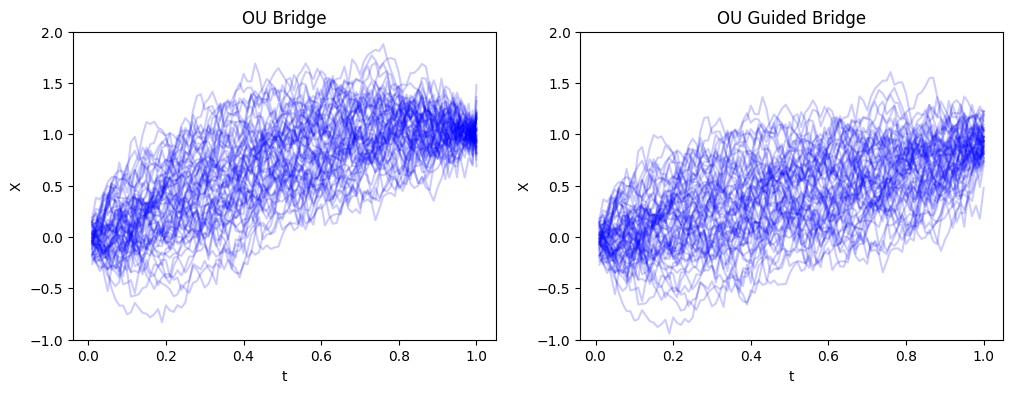

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in range(n_batches):
    axs[0].plot(ou_bridge_path.ts, ou_bridge_path.xs[i, :, 0], color="blue", alpha=0.2)
    axs[1].plot(ou_guided_bridge_path.ts, ou_guided_bridge_path.xs[i, :, 0], color="blue", alpha=0.2)

axs[0].set_title("OU Bridge")
axs[1].set_title("OU Guided Bridge")
axs[0].set_ylim(-1.0, 2.0)
axs[1].set_ylim(-1.0, 2.0)
axs[0].set_xlabel("t")
axs[1].set_xlabel("t")
axs[0].set_ylabel("X")
axs[1].set_ylabel("X")
plt.show()

**Set up a NN**

In [15]:
from flax import linen as nn
from flax.training import train_state
import optax

In [16]:
# a very simple MLP
class MLP(nn.Module):

    @nn.compact
    def __call__(self, t, x):
        t = jnp.expand_dims(t, axis=-1)
        x = jnp.concatenate([t, x], axis=-1)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(1)(x)
        return x

In [35]:
def train_model(rng_key, model, path_solver, n_epochs, batch_size):
    rng_key, init_key = jax.random.split(rng_key)
    
    dummy_t, dummy_x = jnp.zeros((1, )), jnp.zeros((1, 1))
    params = model.init(init_key, dummy_t, dummy_x)
    optimizer = optax.sgd(1e-3)
    
    model_state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer
    )

    def sample_path(rng_key, path_solver):
        path = path_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=batch_size)
        ts, xs = path.ts, path.xs
        ts = jnp.tile(jnp.expand_dims(ts, axis=0), reps=(batch_size, 1))
        return ts, xs
    
    def compute_loss(params, ts, xs, state):
        nus = state.apply_fn(params, ts, xs)
        loss = 0.5 * jnp.mean((jnp.sum(jnp.linalg.norm(nus, axis=-1)**2, axis=1)))
        return loss
    
    @jax.jit
    def train_step(state, ts, xs):
        grad_fn = jax.value_and_grad(compute_loss, has_aux=False)
        loss, grads = grad_fn(state.params, ts, xs, state)
        state = state.apply_gradients(grads=grads)
        return state, loss
    
    losses = []
    for epoch in range(1, n_epochs + 1):
        rng_key, batch_key = jax.random.split(rng_key)
        ts, xs = sample_path(batch_key, path_solver)
        model_state, loss = train_step(model_state, ts, xs)
        losses.append(loss)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, loss: {loss}")
    return model_state, losses

In [36]:
model = MLP()
n_epochs = 1000
batch_size = 32

In [37]:
model_state, losses = train_model(rng_key, model, ou_bridge_solver, n_epochs, batch_size)

Epoch 100, loss: 0.06240280717611313
Epoch 200, loss: 0.03701397776603699
Epoch 300, loss: 0.01562587544322014
Epoch 400, loss: 0.011592593044042587
Epoch 500, loss: 0.006737441290169954
Epoch 600, loss: 0.008173300884664059
Epoch 700, loss: 0.0057406434789299965
Epoch 800, loss: 0.0068297781981527805
Epoch 900, loss: 0.003790003713220358
Epoch 1000, loss: 0.002823646180331707


In [38]:
def nu_learned(t, x):
    return model_state.apply_fn(model_state.params, t, x)

In [39]:
ou_mixed_bridge_proc = MixedGuidedBridgeProcess(
    ori_proc=ou_proc,
    aux_proc=ou_aux_proc,
    nu=nu_learned,
    xT=xT,
    x0=x0,
    L0=L0,
    Sigma0=Sigma0
)

ou_mixed_bridge_solver = Euler(ou_mixed_bridge_proc, wiener_process)
ou_mixed_bridge_path = ou_mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=32)

Text(0.5, 1.0, 'Brownian mixed bridge with trained neural network vs. truth')

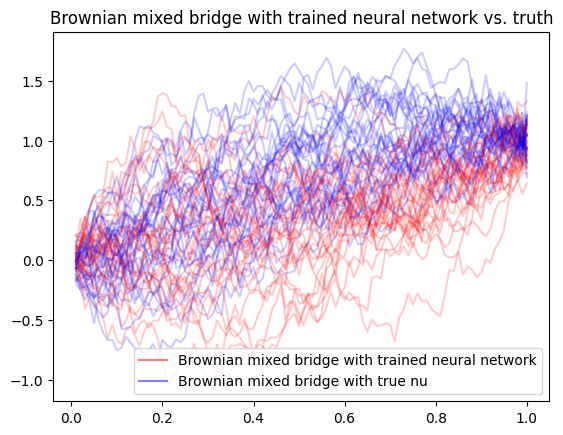

In [40]:
for i in range(32):
    plt.plot(ou_mixed_bridge_proc.ts[1:], ou_mixed_bridge_path.xs[i, :, 0], color="red", alpha=0.2)
    plt.plot(ou_bridge_path.ts, ou_bridge_path.xs[i, :, 0], color="blue", alpha=0.2)
    
plt.plot([], [], color="red", label="Brownian mixed bridge with trained neural network", alpha=0.5)
plt.plot([], [], color="blue", label="Brownian mixed bridge with true nu", alpha=0.5)
plt.legend()
plt.title("Brownian mixed bridge with trained neural network vs. truth")

In [21]:
model = MLP()
n_epochs = 3000
batch_size = 64

In [22]:
# train with estimated score
model_state_estimated = train_model(key, model, brownian_bridge_solver, n_epochs, batch_size, train_with_true_score=False)

Epoch 100, loss: 0.7524476051330566
Epoch 200, loss: 0.28933075070381165
Epoch 300, loss: 0.21405161917209625
Epoch 400, loss: 0.07272318005561829
Epoch 500, loss: 0.024530738592147827
Epoch 600, loss: 0.04783836007118225
Epoch 700, loss: 0.010600339621305466
Epoch 800, loss: 0.0018693888559937477
Epoch 900, loss: -0.027367880567908287
Epoch 1000, loss: -0.007361580617725849
Epoch 1100, loss: 0.03095225989818573
Epoch 1200, loss: -0.035246673971414566
Epoch 1300, loss: -0.05384565144777298
Epoch 1400, loss: -0.023413274437189102
Epoch 1500, loss: 0.0005781130748800933
Epoch 1600, loss: -0.02568696066737175
Epoch 1700, loss: 0.395976722240448
Epoch 1800, loss: -0.001603499986231327
Epoch 1900, loss: -0.014248063787817955
Epoch 2000, loss: -0.025464022532105446
Epoch 2100, loss: -0.010835577733814716
Epoch 2200, loss: -0.01921994425356388
Epoch 2300, loss: -0.04942341893911362
Epoch 2400, loss: -0.03230781853199005
Epoch 2500, loss: -0.054336465895175934
Epoch 2600, loss: -0.025558777153

In [23]:
def nu_estimated_learned(t, x):
    return model_state_estimated.apply_fn(model_state_estimated.params, t, x)

In [24]:
brownian_mixed_bridge_learned = BrownianMixedBridgeProcess(T=T, dt=dt, dim=dim, dtype=dtype, sigma=sigma, nu=nu_estimated_learned, xT=xT)
brownian_mixed_bridge_learned_solver = Euler(brownian_mixed_bridge_learned, wiener_process)
brownian_mixed_bridge_learned_path = brownian_mixed_bridge_learned_solver.solve(x0=x0, dWs=None, rng_key=key5, n_batches=n_batches)

Text(0.5, 1.0, 'Brownian mixed bridge with trained neural network vs. true nu')

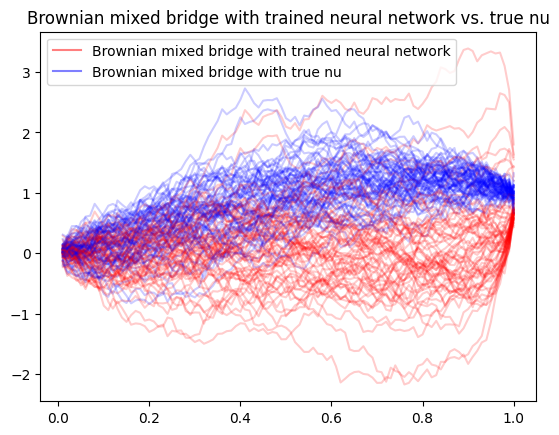

In [25]:
for i in range(n_batches):
    plt.plot(brownian_mixed_bridge_learned.ts[1:], brownian_mixed_bridge_learned_path.xs[i, :, 0], color="red", alpha=0.2)
    plt.plot(brownian_mixed_bridge_true.ts[1:], brownian_mixed_bridge_true_path.xs[i, :, 0], color="blue", alpha=0.2)

plt.plot([], [], color="red", label="Brownian mixed bridge with trained neural network", alpha=0.5)
plt.plot([], [], color="blue", label="Brownian mixed bridge with true nu", alpha=0.5)
plt.legend()
plt.title("Brownian mixed bridge with trained neural network vs. true nu")